# Run alternative versions of the FastScape landscape evolution model

Let's import some packages first (you can install them using ``conda``).

In [1]:
import numpy as np
import xarray as xr
import xsimlab as xs
import fastscape

In [2]:
print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.4.1
fastscape version:  0.1.0beta


## Generate an alternative model from an existing model

Most of the time we don't want to create new models from scratch, but instead just change one or several components. The ``xarray-simlab`` framework allows to do that very easily.

Let's first import the basic (standard) model.

In [3]:
from fastscape.models import basic_model

basic_model

<xsimlab.Model (16 processes, 8 inputs)>
grid
    length          [in] ('shape_yx',) total grid length in (y, x)
    shape           [in] ('shape_yx',) nb. of grid nodes in (y, x)
fs_context
boundary
    status          [in] () or ('border',) node status at borders
uplift
    rate            [in] () or ('y', 'x') uplift rate
tectonics
init_topography
surf2erode
diffusion
    diffusivity     [in] () or ('y', 'x') diffusivity (transport co...
flow
drainage
spl
    k_coef          [in] () or ('y', 'x') bedrock channel incision ...
    area_exp        [in] drainage area exponent
    slope_exp       [in] slope exponent
init_erosion
erosion
vmotion
topography
terrain

The ``fastscape`` package also contains a bunch of ``xarray-simlab`` components (called processes) that you can reuse to create new models. In the example below, we create a model variant in which we use multiple direction flow routing:  

In [4]:
from fastscape.processes import MultipleFlowRouter

mfd_model = basic_model.update_processes({'flow': MultipleFlowRouter})

Compared to ``basic_model``, you can see that ``mfd_model`` as one additional input:

In [5]:
mfd_model

<xsimlab.Model (16 processes, 9 inputs)>
grid
    length          [in] ('shape_yx',) total grid length in (y, x)
    shape           [in] ('shape_yx',) nb. of grid nodes in (y, x)
fs_context
boundary
    status          [in] () or ('border',) node status at borders
uplift
    rate            [in] () or ('y', 'x') uplift rate
tectonics
init_topography
surf2erode
diffusion
    diffusivity     [in] () or ('y', 'x') diffusivity (transport co...
flow
    slope_exp       [in] MFD partioner slope exponent
drainage
spl
    k_coef          [in] () or ('y', 'x') bedrock channel incision ...
    area_exp        [in] drainage area exponent
    slope_exp       [in] slope exponent
init_erosion
erosion
vmotion
topography
terrain

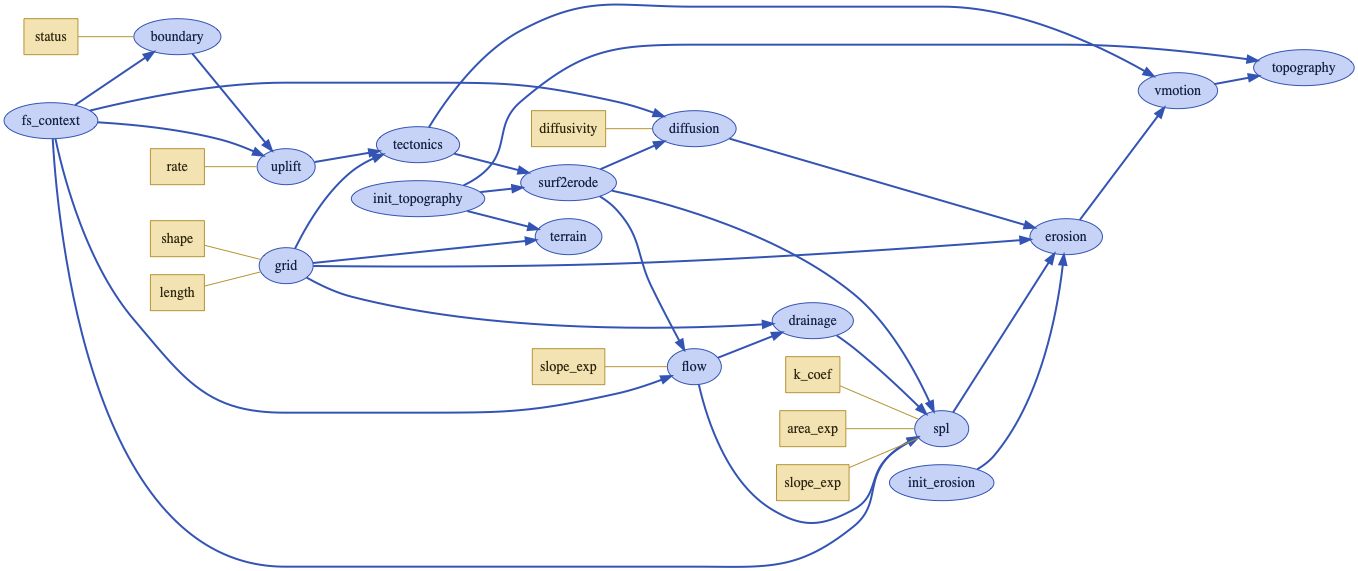

In [6]:
mfd_model.visualize(show_inputs=True)

It is also possible to drop components. For example, disable diffusion:

In [7]:
no_diff_model = basic_model.drop_processes('diffusion')

no_diff_model

<xsimlab.Model (15 processes, 7 inputs)>
grid
    shape         [in] ('shape_yx',) nb. of grid nodes in (y, x)
    length        [in] ('shape_yx',) total grid length in (y, x)
fs_context
boundary
    status        [in] () or ('border',) node status at borders
uplift
    rate          [in] () or ('y', 'x') uplift rate
tectonics
init_topography
surf2erode
flow
drainage
spl
    k_coef        [in] () or ('y', 'x') bedrock channel incision co...
    area_exp      [in] drainage area exponent
    slope_exp     [in] slope exponent
init_erosion
erosion
vmotion
topography
terrain

``xarray-simlab`` doesn't allow creating models that break the workflow (graph of components). For example:

In [8]:
basic_model.drop_processes('flow')

KeyError: "Process class 'FlowRouter' missing in Model but required by foreign variable 'stack' declared in process 'drainage'"

## Reuse model setups

Likewise, most of the time we want to slightly modify an existing setup instead of creating a new setup from srcatch. In this case too, ``xarray-simlab`` allows to easily reuse and tweak model setup, even when using different model variants.

Let's import below the setup that we have created in the ``run_basic_model`` notebook:

In [9]:
in_ds = xr.load_dataset('basic_input.nc')

in_ds

<xarray.Dataset>
Dimensions:                 (border: 4, out: 11, shape_yx: 2, time: 101)
Coordinates:
  * time                    (time) float64 0.0 1e+04 2e+04 ... 9.9e+05 1e+06
  * out                     (out) float64 0.0 1e+05 2e+05 ... 8e+05 9e+05 1e+06
Dimensions without coordinates: border, shape_yx
Data variables:
    grid__shape             (shape_yx) int64 101 201
    grid__length            (shape_yx) float64 1e+04 2e+04
    boundary__status        (border) object 'looped' 'looped' ... 'fixed_value'
    uplift__rate            float64 0.001
    spl__k_coef             float64 0.0001
    spl__area_exp           float64 0.4
    spl__slope_exp          float64 1.0
    diffusion__diffusivity  float64 0.1
Attributes:
    __xsimlab_output_vars__:  spl__chi

As the ``xarray-simlab`` API takes and returns ``xarray.Datasets`` objects, a common and tidy worflow is chain operations, like updating the setup and run the model (and do some post-processing). Let's setup and run a simulation using multiple flow routing:

In [10]:
in_vars = {'flow__slope_exp': 1.5}

with mfd_model:
    out_ds = (
        in_ds.xsimlab.filter_vars()
             .xsimlab.update_vars(input_vars=in_vars)
             .xsimlab.run()
    )
    
out_ds

<xarray.Dataset>
Dimensions:                 (border: 4, out: 11, shape_yx: 2, time: 101, x: 201, y: 101)
Coordinates:
  * border                  (border) <U6 'left' 'right' 'top' 'bottom'
  * out                     (out) float64 0.0 1e+05 2e+05 ... 8e+05 9e+05 1e+06
  * time                    (time) float64 0.0 1e+04 2e+04 ... 9.9e+05 1e+06
  * x                       (x) float64 0.0 100.0 200.0 ... 1.99e+04 2e+04
  * y                       (y) float64 0.0 100.0 200.0 ... 9.9e+03 1e+04
Dimensions without coordinates: shape_yx
Data variables:
    boundary__status        (border) object 'looped' 'looped' ... 'fixed_value'
    diffusion__diffusivity  float64 0.1
    drainage__area          (out, y, x) float64 2.042e+04 ... 6.648e+04
    flow__basin             (out, y, x) int64 3228 16405 19956 ... 13999 1663
    flow__slope_exp         float64 1.5
    grid__length            (shape_yx) float64 1e+04 2e+04
    grid__shape             (shape_yx) int64 101 201
    spl__area_exp        

Let's look at the topography:

In [11]:
import hvplot.xarray
import matplotlib.pyplot as plt

out_ds.topography__elevation.hvplot.image(x='x', y='y',
                                          cmap=plt.cm.viridis,
                                          groupby='out')

:DynamicMap   [out]
   :Image   [x,y]   (topography__elevation)